# Machine Learning - Ex3
### Haim Goldfisher 315599563 & Itamar Kraitman 208925578

#### Project Objective
Since November 2022, when OpenAI introduced ChatGPT 3, the world of LLMs has been spread like wildfire. LLMs have been introduced almost every month, and ease the ability to create text, based on simple instructions.
Those LLM models are helpful in a large number of life aspects. they give the ability to expand knowledge easily, write essays faster, and more.
Those LLms also became a useful tool for students, to overcome difficulties in their studies. This phenomenon spread so much, that students started to cheat and hand in assignments fully generated by AI, which forced the lectures to develop abilities to identify whether the students "cheated" or wrote the assignment themselves.
In this project, we'll try to build a model, that could help the ones standing on the side, from paper and website readers to academic lectures, to identify whether the text they read, was written by a human being, or it is penned by an AI tool.



#### Importing Needed Libraries

In [1]:

import numpy as np
import pandas as pd
import random
import zipfile
import pickle
import re
import string
from collections import Counter
from joblib import dump
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
nlp = spacy.load("en_core_web_sm") # english small version
import nltk
from nltk import FreqDist, pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.sentiment import SentimentIntensityAnalyzer
from statistics import mean
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

# Google Colab API
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


#### Reading the data set

In [2]:
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/AI_Vs_Human_Text.zip', 'r') as zip_ref:
    with zip_ref.open('AI_Human.csv') as file:
        raw_data = pd.read_csv(file)
        raw_data['generated'] = raw_data['generated'].astype(np.int8)

In [3]:
raw_data.sample(4, random_state=555)

,text,generated
9819,"As you know, as a scientist we come across man...",0
472085,"As an average 8th grape student, I have always...",1
92993,Fellow citizens should know the advantages of ...,0
246782,Fact is reality and people have to face the re...,1


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       487235 non-null  object
 1   generated  487235 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 4.2+ MB


We decided to remove texts with length lower than 5 because we wanted to keep only texts with meaning

In [ ]:
raw_data = raw_data[raw_data['text'].str.len() > 5]

In [ ]:
# size of the dataset in MB

size_in_bytes = raw_data.memory_usage().sum()
size_in_kb = size_in_bytes / 1024
size_in_mb = size_in_kb / 1024
print(f"The size of the dataset is {size_in_mb:.2f} MB")

The size of the dataset is 4.18 MB


#### The data set is imbalanced.
Our first attempt was to add samples, but it made the data set too large to compute all needed functions and algorithms with the amout of memmory we have.
Therfore, we decided to go with the approach of down sampeling, and take only ~10,000 samples of each class.

In [ ]:
raw_data['generated'].value_counts()

0    305797
1    181438
Name: generated, dtype: int64

In [ ]:
mapper = {1 : 'AI',
          0 : 'Human'}

human_samples = raw_data[raw_data['generated'] == 0].sample(n=10000, random_state=42)
ai_samples =  raw_data[raw_data['generated'] == 1].sample(n=10000, random_state=42)

data = pd.concat([human_samples, ai_samples])
data['generated'].value_counts()

0    10000
1    10000
Name: generated, dtype: int64

In [ ]:
def plot_pie(value_counts_summary):
  print(value_counts_summary, "\n")

  plt.figure(figsize=(8, 6))
  sns.set_palette("pastel")
  plt.pie(value_counts_summary, labels=value_counts_summary.index, autopct='%1.1f%%', startangle=140)
  plt.axis('equal')
  plt.title('Ratio Between AI and Human Generated Text')
  plt.show()

Human    10000
AI       10000
Name: generated, dtype: int64 



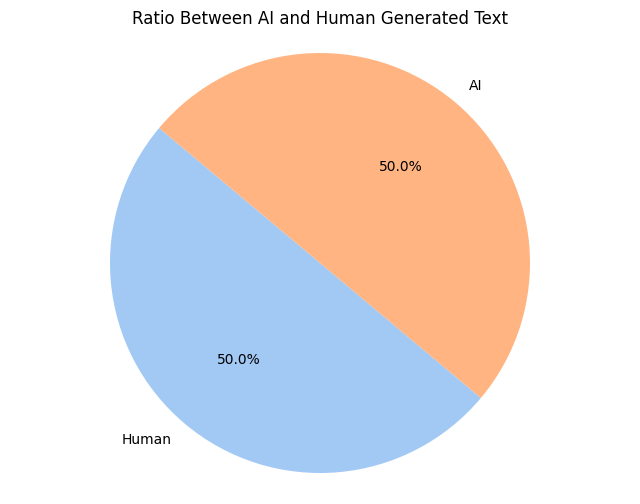

In [ ]:
# the ratio between the labels

plot_pie(value_counts_summary=data['generated'].map(mapper).value_counts())

#### Data Cleaning

##### Checking for NaN values

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 260481 to 249342
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       20000 non-null  object
 1   generated  20000 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 332.0+ KB


##### checking for duplicates


In [ ]:
data.duplicated(subset=['text']).sum()

0

##### There are no duplicated values

Human    10000
AI       10000
Name: generated, dtype: int64 



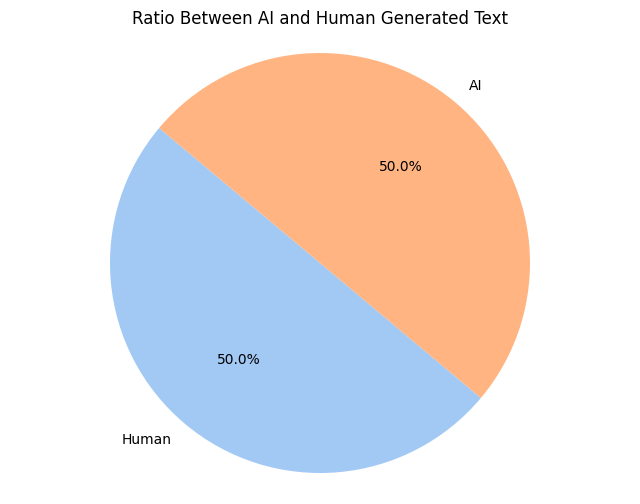

In [ ]:
data.drop_duplicates(subset='text', inplace=True)

data.reset_index(inplace=True)
data.drop(columns=['index'], inplace=True)

plot_pie(data['generated'].map(mapper).value_counts())

##### Removing punctuation and convert to lowercase


In [ ]:
only_words_data = data.copy()

pattern = re.compile('[^ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,\'"-?:)(!/;_\\[\\] ]')
only_words_data['text'] = only_words_data['text'].apply(lambda row: pattern.sub('' ,row))
data['text'] = data['text'].apply(lambda row: pattern.sub('' ,row))

In [ ]:
data['text'].to_csv('text_df.csv', index=False)

### Exploratory Data Analysis

We assume that:
1. AI-generated writing may lack emotion or personality, resulting in a robotic or flat tone.
2. AI-generated might sometimes be repetitive or inconsistent text, as it may be based on multiple sources of information.
3. AI-generated might be highly fluent and natural sounding text, but may someitimes has errors in grammar of syntax.

sources:
https://aicontentfy.com/en/blog/unmasking-ai-guide-to-detecting-artificially-generated-content



##### length distribution

Min length is: 22, Max length is: 8163, Mean length is: 2219.18675



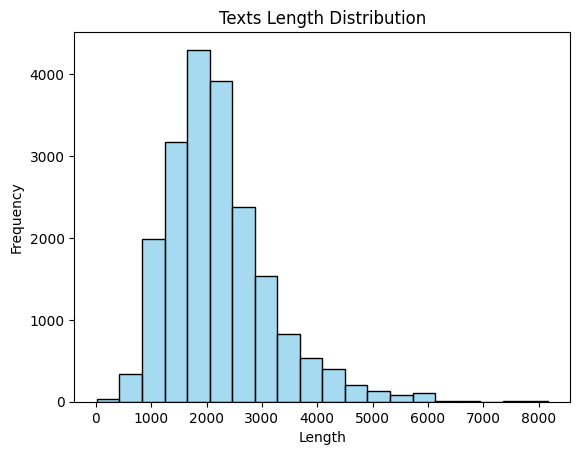

In [ ]:
text_lengths = data['text'].str.len()
print(f"Min length is: {text_lengths.min()}, Max length is: {text_lengths.max()}, Mean length is: {text_lengths.mean()}\n")

sns.histplot(text_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title("Texts Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

We can observe that the length of the texts is mostly between
1,000-3,000 tokens

##### Length by class distribution

Human Min length is: 518, Max length is: 8044, Mean length is: 2321.4089

AI Min length is: 22, Max length is: 8163, Mean length is: 2116.9646



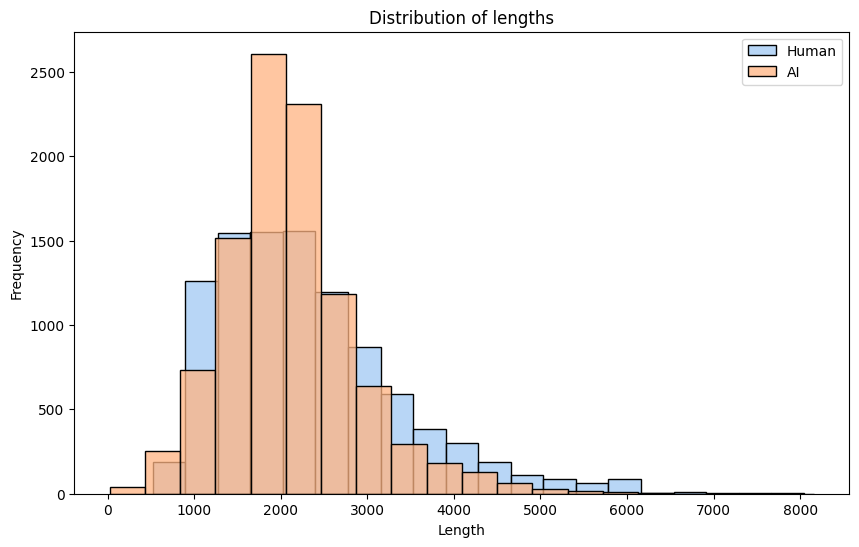

In [ ]:
group_by_generated = data.groupby(data['generated'])

plt.figure(figsize=(10, 6))
for name, group in group_by_generated:
  group_lengths = group['text'].str.len()
  name = 'AI' if name == 1 else 'Human'

  print(f"{name} Min length is: {group_lengths.min()}, Max length is: {group_lengths.max()}, Mean length is: {group_lengths.mean()}\n")
  sns.histplot(group_lengths, bins=20, edgecolor='black')

plt.title('Distribution of lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend(['Human', 'AI'])
plt.show()



From the distributions we can conclude two main insights:
1. <b>Legnth matters:</b> Human generated text is mostly longer than AI generated text.
2. <b>Wide Distribution:</b> AI generated text is more widely distributed than Human generated text.

##### Using of stop words

we would like to show the 10 most common words in the dataset


In [ ]:
def ten_most_common_words(data):
  batch_size = 100 # count in small batches to protect RAM memory
  most_common_size = 10

  word_counts = Counter()
  for i in range(0, len(data['text']), batch_size):
    batch = data['text'][i:i+batch_size]
    for text in batch:
      word_counts.update(text.split())

  return sorted(word_counts.most_common(most_common_size), key=lambda x: x[1], reverse=True)

most_common_words = ten_most_common_words(only_words_data)
print(f"Ten most common words are genarated texts are: {most_common_words}")

Ten most common words are genarated texts are: [('the', 309708), ('to', 257179), ('and', 205399), ('a', 176930), ('of', 161747), ('that', 110576), ('in', 108012), ('is', 104407), ('for', 71832), ('be', 69839)]


In [ ]:
only_words_groupby_generated = only_words_data.groupby(only_words_data['generated'])

most_common_words_ai = ten_most_common_words(only_words_groupby_generated.filter(lambda row: row['generated'].iloc[0] == 1))
most_common_words_human = ten_most_common_words(only_words_groupby_generated.filter(lambda row: row['generated'].iloc[0] == 0))

print(f"Ten most common words for AI genarated texts are: {most_common_words_ai}\nTen most common words for human genarated texts are: {most_common_words_human}\n")

Ten most common words for AI genarated texts are: [('the', 132646), ('to', 116524), ('and', 114342), ('of', 83151), ('a', 82351), ('in', 50831), ('that', 46746), ('is', 44068), ('can', 39572), ('for', 33273)]
Ten most common words for human genarated texts are: [('the', 177062), ('to', 140655), ('a', 94579), ('and', 91057), ('of', 78596), ('that', 63830), ('is', 60339), ('in', 57181), ('you', 45185), ('be', 43387)]



### Features engineering

In [ ]:
def add_features(data_to_modify):
    """
    Function to add features to the dataset
    """
    # utils lists
    sia = SentimentIntensityAnalyzer()
    punctuation_types = ['.', ',', "'", '"', '-', '?', ':', ')', '(', '!', '/', ';', '_', ']', '[']
    subordinating_conjunctions = ["after",
      "although",
      "as",
      "as far as",
      "as if",
      "as long as",
      "as soon as",
      "as though",
      "because",
      "before",
      "even if",
      "even though",
      "if",
      "if only",
      "if when",
      "inasmuch as",
      "in order that",
      "now that",
      "once",
      "provided that",
      "rather than",
      "since",
      "so that",
      "supposing",
      "than",
      "though",
      "till",
      "unless",
      "until",
      "when",
      "whenever",
      "where",
      "whereas",
      "wherever",
      "whether",
      "while",
      "why"]

    data = data_to_modify.copy()

    # functions
    def count_punctuation_row(text):
      """
      Function to compute punctuation ratio in text
      """
      count = sum(char in punctuation_types for char in text)
      return round(count/len(text), 3)*100

    def evaluate_tone(text):
      """
      Evaluate the tone of a text and return a score indicating the presence of emotion/personality.
      Higher scores suggest a more emotional or personalized tone, while lower scores suggest a robotic or flat tone.
      """
      # Analyze sentiment of the text
      sentiment_scores = sia.polarity_scores(text)

      # Calculate a score indicating the presence of emotion/personality
      tone_score = sentiment_scores['compound']

      return tone_score

    def get_sentiment(text):
      """
      This function takes a text as input and returns a dictionary containing the sentiment scores for the text.
      """
      sentiment_scores = sia.polarity_scores(text)
      return sentiment_scores

    def divide_sentiment_to_categories(data):
      longest_sentiment_dictionary = 0
      sentiments = []

      for row in data['Sentiment']:
        if len(row) > longest_sentiment_dictionary:
          longest_sentiment_dictionary = len(row)
          sentiments = row.keys()

      # add each sentiment section to the data frame as a column
      sentiments_dictionaries = [row for row in data['Sentiment']]
      sentiments_data = pd.DataFrame(data=sentiments_dictionaries)
      data = pd.concat([data, sentiments_data], axis=1)
      data.drop(['Sentiment'], axis=1, inplace=True)

      return data

    def richness(text):
      """
      This function takes a text as input and returns the richness of the text.
      """
      tokens = word_tokenize(text)
      unique_tokens = set(tokens)
      richness = len(unique_tokens) / len(tokens)
      return richness

    def count_char_percent(text, char):
      """
      This function takes a text and a character as input and returns the percentage of the character in the text.
      """
      count = text.count(char)
      percent = count / len(text) * 100
      return percent

    def get_pos_tags(text):
        """
        This function returns a dictionary of the percentages of each part of speech in a given text.
        """
        pos_tags = nltk.pos_tag(word_tokenize(text))
        counts = Counter(tag for word, tag in pos_tags)
        total_words = len(pos_tags)

        # Check if total_words is zero to avoid division by zero
        if total_words == 0:
            return {
                "Nouns": 0,
                "Pronouns": 0,
                "Verbs": 0,
                "Adjectives": 0,
                "Adverbs": 0,
                "Prepositions": 0,
                "Conjunctions": 0,
                "Interjections": 0
            }

        pos_percentages = {
            "Nouns": (counts["NN"] + counts["NNS"]) / total_words,
            "Pronouns": (counts["PRP"] + counts["PRP$"]) / total_words,
            "Verbs": (counts["VB"] + counts["VBD"] + counts["VBG"] + counts["VBN"] + counts["VBP"] + counts["VBZ"]) / total_words,
            "Adjectives": (counts["JJ"] + counts["JJR"] + counts["JJS"]) / total_words,
            "Adverbs": (counts["RB"] + counts["RBR"] + counts["RBS"]) / total_words,
            "Prepositions": (counts["IN"]) / total_words,
            "Conjunctions": (counts["CC"]) / total_words,
            "Interjections": (counts["UH"]) / total_words,
        }
        return pos_percentages

    def divide_pos_to_categories(data):
      longest_pos_dictionary = 0
      pos = []

      for row in data['POS_tags']:
        if len(row) > longest_pos_dictionary:
          longest_pos_dictionary = len(row)
          pos = row.keys()

      # add each sentiment section to the data frame as a column
      pos_dictionaries = [row for row in data['POS_tags']]
      pos_data = pd.DataFrame(data=pos_dictionaries)
      data = pd.concat([data, pos_data], axis=1)
      data.drop(['POS_tags'], axis=1, inplace=True)

      return data

    def get_entities(text):
      entities = nlp(text).ents
      return entities

    def entities_text_length_ratio(entities, text):
      return len(entities) / len(text)

    def get_stopwords_percent(text):
        stop_words = set(nltk.corpus.stopwords.words('english'))
        words = word_tokenize(text)
        stopwords_count = sum(1 for word in words if word in stop_words)
        total_words = len(words)
        stopwords_percent = stopwords_count / total_words * 100
        return stopwords_percent

    def get_uppercase_percent(text):
        uppercase_count = sum(1 for char in text if char.isupper())
        total_chars = len(text)
        uppercase_percent = uppercase_count / total_chars * 100
        return uppercase_percent

    # Flesch-Kincaid Grade Level or Gunning Fog Index, which estimate the readability level of the text

    def flesch_reading_ease(text):
      """
      This function calculates the Flesch Reading Ease score for a given text.
      """
      words = text.split()
      sentences = text.count('.') + text.count('?') + text.count('!')
      syllables = sum(sum(1 for c in word if c.lower() in 'aeiou') for word in words)

      if sentences == 0:
        sentences = 1
      score = 206.835 - 1.015 * (len(words) / sentences) - 84.6 * (syllables / len(words))
      return score

    def flesch_kincaid_grade_level(text):
      """
      This function calculates the Flesch-Kincaid Grade Level for a given text.
      """
      score = flesch_reading_ease(text)

      grade_level = (0.39 * score) + 11.8
      return grade_level

    def gunning_fog_index(text):
      """
      This function calculates the Gunning Fog Index for a given text.
      """
      words = text.split()
      sentences = text.count('.') + text.count('?') + text.count('!')
      complex_words = sum(1 for word in words if len(word) >= 3 and sum(1 for c in word if c.lower() in 'aeiou') > 2)

      if sentences == 0:
        sentences = 1

      score = 0.4 * ((len(words) / sentences) + 100 * (complex_words / len(words)))
      return score

    def count_subordinate_clauses(text):
      """
      This function counts the number of subordinate clauses in a given text.
      """
      subordinate_clauses = 0
      for sentence in sent_tokenize(text):
        for word in sentence.split():
          if word in subordinating_conjunctions:
            subordinate_clauses += 1

      return subordinate_clauses

    def count_independent_clauses(text):
      """
      This function counts the number of independent clauses in a given text.
      """
      independent_clauses = 0
      for sentence in sent_tokenize(text):
        if not any(word in subordinating_conjunctions for word in sentence.split()):
          independent_clauses += 1
      return independent_clauses

    def syntactic_complexity(text):
      """
      This function calculates the syntactic complexity of a given text.
      """
      subordinate_clauses = count_subordinate_clauses(text)
      independent_clauses = count_independent_clauses(text)

      if independent_clauses == 0:
        return 0
      else:
        return subordinate_clauses / independent_clauses

    def average_sentence_length(text):
        """
        This function calculates the average sentence length for a given text.
        """
        sentences = sent_tokenize(text)
        words_per_sentence = [len(sentence.split()) for sentence in sentences]
        average_length = sum(words_per_sentence) / len(sentences)
        return average_length



    # Punctuation precent
    data['punctuation%'] = data['text'].apply(lambda row: count_punctuation_row(row))
    # Tone
    data['tone'] = data['text'].apply(lambda row: evaluate_tone(row))
    # Sentiment
    data['Sentiment'] = data['text'].apply(get_sentiment)
    data = divide_sentiment_to_categories(data)
    # Richness
    data['Richness'] = data['text'].apply(richness)
    # features of '.' , ',' and '?'
    data['%_comma'] = data['text'].apply(lambda x: count_char_percent(x, ','))
    data['%_period'] = data['text'].apply(lambda x: count_char_percent(x, '.'))
    data['%_q_mark'] = data['text'].apply(lambda x: count_char_percent(x, '?'))
    # POS
    data['POS_tags'] = data['text'].apply(get_pos_tags)
    data = divide_pos_to_categories(data)
    # Entities
    data['Entities'] = data['text'].apply(get_entities)
    # Entities ratio
    data['Entities_ratio'] = data.apply(lambda row: entities_text_length_ratio(row['Entities'], row['text']), axis=1)
    data.drop('Entities', axis=1, inplace=True)
    # stop words
    data['%_stopwords'] = data['text'].apply(get_stopwords_percent)
    # upper case
    data['%_uppercase'] = data['text'].apply(get_uppercase_percent)
    # test_length
    data['text_length'] = data['text'].apply(lambda x: len(x))
    # num words
    data['num_words'] = data['text'].apply(lambda x: len(x.split()))
    # Flesch-Kincaid Grade Level or Gunning Fog Index
    data['FleschReadingEase'] = data['text'].apply(flesch_reading_ease)
    data['FleschKincaidGradeLevel'] = data['text'].apply(flesch_kincaid_grade_level)
    data['GunningFogIndex'] = data['text'].apply(gunning_fog_index)
    # syntactic complexity
    data['SyntacticComplexity'] = data['text'].apply(syntactic_complexity)
    # average sentence length
    data['AverageSentenceLength'] = data['text'].apply(average_sentence_length)

    return data

In [ ]:
data = add_features(data)
data.head()

,text,generated,punctuation%,tone,neg,neu,pos,compound,Richness,%_comma,...,Entities_ratio,%_stopwords,%_uppercase,text_length,num_words,FleschReadingEase,FleschKincaidGradeLevel,GunningFogIndex,SyntacticComplexity,AverageSentenceLength
0,Do curfews keep teenagers from Getting into tr...,0,2.4,0.9711,0.111,0.760,0.129,0.9711,0.376357,0.425638,...,0.006259,44.149578,1.952929,3994,745,54.704828,33.134883,11.387405,0.571429,18.170732
1,"In this article ""The Challenge of Exploring Ve...",0,2.1,0.9854,0.056,0.812,0.131,0.9854,0.535070,1.026393,...,0.010264,39.078156,1.759531,2728,446,26.700755,22.213294,17.912278,1.090909,27.875000
2,With THP rapid growth of THP Internet in recen...,0,1.7,-0.7422,0.072,0.857,0.071,-0.7422,0.414209,0.883002,...,0.010792,34.316354,5.837626,4077,680,37.589485,26.459899,17.205882,1.142857,24.285714
3,The electoral College is the way Us United Sta...,0,2.2,0.9898,0.034,0.862,0.103,0.9898,0.364230,0.258532,...,0.009049,42.819843,2.481903,3868,685,35.567578,25.671355,16.368248,1.250000,23.724138
4,This technology of you can calculate the emoti...,0,2.2,0.7003,0.068,0.820,0.113,0.7003,0.444737,0.685293,...,0.004217,43.947368,2.003163,1897,341,49.628750,31.155213,12.382048,0.533333,17.050000


### Punctuation Analysis

In [ ]:
punctuation_types = ['.', ',', "'", '"', '-', '?', ':', ')', '(', '!', '/', ';', '_', ']', '[']

def count_punctuations_data(data):
  punctuation_counts = {char: 0 for char in punctuation_types}

  for text in data:
    for char in text:
      if char in punctuation_types:
        punctuation_counts[char] += 1

  punctuation_count_sorted = dict(sorted(punctuation_counts.items(), key=lambda x: x[1], reverse=True))

  for char, count in punctuation_count_sorted.items():
    print(f"Character '{char}' appears {count} times.")

  return punctuation_count_sorted

data_punctiuation_count = count_punctuations_data(data['text'])

Character '.' appears 386789 times.
Character ',' appears 365524 times.
Character ''' appears 90007 times.
Character '"' appears 39875 times.
Character '-' appears 13669 times.
Character '?' appears 11604 times.
Character '!' appears 7140 times.
Character ':' appears 6853 times.
Character ')' appears 6135 times.
Character '(' appears 6053 times.
Character '_' appears 3499 times.
Character ';' appears 2977 times.
Character ']' appears 2863 times.
Character '[' appears 2808 times.
Character '/' appears 2415 times.


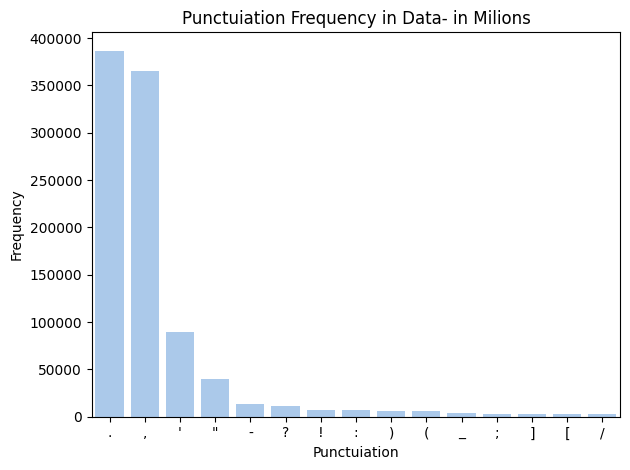

In [ ]:
sns.barplot(data=data_punctiuation_count)
plt.xlabel('Punctuiation')
plt.ylabel('Frequency')
plt.title('Punctuiation Frequency in Data- in Milions')

plt.tight_layout()
plt.show()

In [ ]:
print("Punctuiation count of AI generateed text:")
punctuation_count_ai = count_punctuations_data(data.groupby('generated').filter(lambda row: row['generated'].iloc[0] == 1)['text'])

print("\nPunctuiation count of human generateed text:")
punctuation_count_human = count_punctuations_data(data.groupby('generated').filter(lambda row: row['generated'].iloc[0] == 0)['text'])

Punctuiation count of AI generateed text:
Character ',' appears 207340 times.
Character '.' appears 178151 times.
Character ''' appears 36447 times.
Character '-' appears 9126 times.
Character '"' appears 8221 times.
Character ':' appears 4856 times.
Character '!' appears 4180 times.
Character '?' appears 3569 times.
Character ')' appears 2652 times.
Character ']' appears 2618 times.
Character '(' appears 2614 times.
Character '[' appears 2551 times.
Character ';' appears 605 times.
Character '/' appears 464 times.
Character '_' appears 375 times.

Punctuiation count of human generateed text:
Character '.' appears 208638 times.
Character ',' appears 158184 times.
Character ''' appears 53560 times.
Character '"' appears 31654 times.
Character '?' appears 8035 times.
Character '-' appears 4543 times.
Character ')' appears 3483 times.
Character '(' appears 3439 times.
Character '_' appears 3124 times.
Character '!' appears 2960 times.
Character ';' appears 2372 times.
Character ':' appear

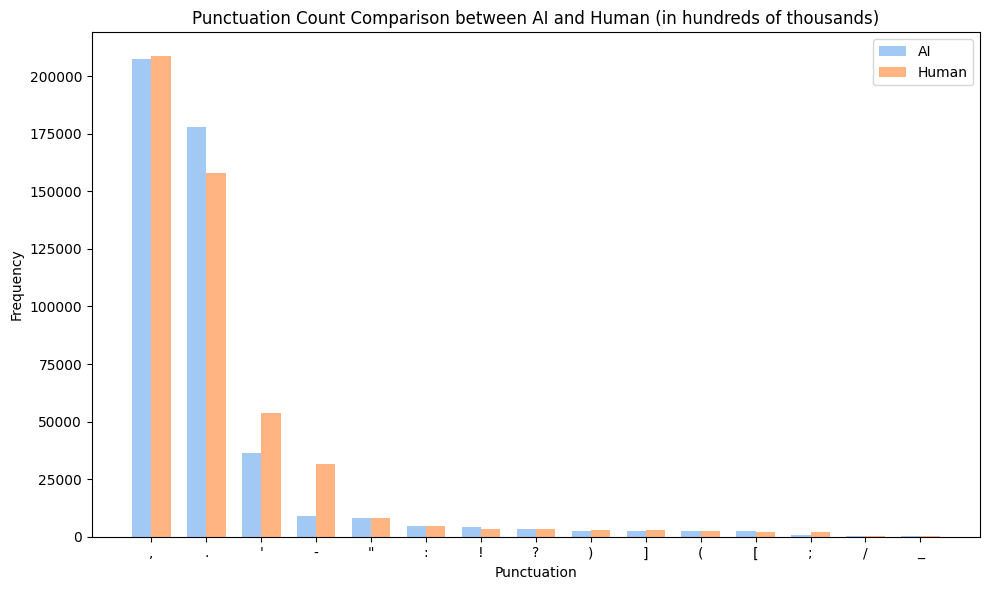

In [ ]:
keys, values_ai, values_human = list(punctuation_count_ai.keys()), list(punctuation_count_ai.values()), list(punctuation_count_human.values())

punctiuation_data_by_generated = pd.DataFrame(data={'Keys' : keys, 'AI' : values_ai, 'Human' : values_human})

keys = punctiuation_data_by_generated['Keys']
values_ai = punctiuation_data_by_generated['AI']
values_human = punctiuation_data_by_generated['Human']

bar_width = 0.35

# Set the x locations for the groups
index = np.arange(len(keys))

# Plotting the bars
plt.figure(figsize=(10, 6))
plt.bar(index, values_ai, bar_width, label='AI')
plt.bar(index + bar_width, values_human, bar_width, label='Human')

# Add labels and title
plt.xlabel('Punctuation')
plt.ylabel('Frequency')
plt.title('Punctuation Count Comparison between AI and Human (in hundreds of thousands)')
plt.xticks(index + bar_width / 2, keys)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# features of '.' , ',' and '?'

mean_comma_by_generated = data.groupby('generated')['%_comma'].mean()
mean_period_by_generated = data.groupby('generated')['%_period'].mean()
mean_q_mark_by_generated = data.groupby('generated')['%_q_mark'].mean()

mean_comma_by_generated.rename(index=mapper, inplace=True)
mean_period_by_generated.rename(index=mapper, inplace=True)
mean_q_mark_by_generated.rename(index=mapper, inplace=True)

print(f"Mean comma by Generated Class: {mean_comma_by_generated}\n")
print(f"Mean period by Generated Class: {mean_period_by_generated}\n")
print(f"Mean question mark Generated Class: {mean_q_mark_by_generated}")

Mean comma by Generated Class: generated
Human    0.651917
AI       0.981364
Name: %_comma, dtype: float64

Mean period by Generated Class: generated
Human    0.922194
AI       0.860615
Name: %_period, dtype: float64

Mean question mark Generated Class: generated
Human    0.036218
AI       0.020655
Name: %_q_mark, dtype: float64


### Sentiment analysis

In [ ]:
sia = SentimentIntensityAnalyzer()

def evaluate_tone(text):
    """
    Evaluate the tone of a text and return a score indicating the presence of emotion/personality.
    Higher scores suggest a more emotional or personalized tone, while lower scores suggest a robotic or flat tone.
    """
    # Analyze sentiment of the text
    sentiment_scores = sia.polarity_scores(text)

    # Calculate a score indicating the presence of emotion/personality
    tone_score = sentiment_scores['compound']

    return tone_score

# Calculating tone score for each class
ai_generaed_tone_score, human_generaed_tone_score = [], []

for index, row in data.iterrows():
  tone_score = evaluate_tone(row['text'])
  ai_generaed_tone_score.append(tone_score) if row['generated'] == 1 else human_generaed_tone_score.append(tone_score)

# Computing tone mean value of each class
ai_generaed_tone_score_mean = mean(ai_generaed_tone_score)
human_generaed_tone_score_mean = mean(human_generaed_tone_score)

print(f"AI generated text tone mean is {ai_generaed_tone_score_mean}\nHuman generated text tone mean is {human_generaed_tone_score_mean}")

AI generated text tone mean is 0.85840099
Human generated text tone mean is 0.59922622


### Richness analysis

In [ ]:
mean_richness_by_generated = data.groupby('generated')['Richness'].mean()
mean_richness_by_generated.rename(index=mapper, inplace=True)

print(f"Mean Richness by Generated Class: {mean_richness_by_generated}")


Mean Richness by Generated Class: generated
Human    0.439440
AI       0.455726
Name: Richness, dtype: float64


### Features engineering summary

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   text                     20000 non-null  object 
 1   generated                20000 non-null  int8   
 2   punctuation%             20000 non-null  float64
 3   tone                     20000 non-null  float64
 4   neg                      20000 non-null  float64
 5   neu                      20000 non-null  float64
 6   pos                      20000 non-null  float64
 7   compound                 20000 non-null  float64
 8   Richness                 20000 non-null  float64
 9   %_comma                  20000 non-null  float64
 10  %_period                 20000 non-null  float64
 11  %_q_mark                 20000 non-null  float64
 12  Nouns                    20000 non-null  float64
 13  Pronouns                 20000 non-null  float64
 14  Verbs                 


### Saving the data for later use

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/add_features.joblib'

with open(path, 'wb') as f:
    try:
      dump(add_features, path)
      print("Function 'add_features' saved successfully.")
    except Exception as e:
      print("Error occurred while saving the function:", e)

Function 'add_features' saved successfully.


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/data_AI_Human.csv'

try:
    data.to_csv(file_path, index=False, encoding='utf-8')
    print("DataFrame successfully saved to:", file_path)
except Exception as e:
    print("Error occurred while saving the DataFrame:", e)

DataFrame successfully saved to: /content/drive/MyDrive/Colab Notebooks/data_AI_Human.csv
